In [34]:
import re 
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from simhash import Simhash
import matplotlib.pyplot as plt

# 核心算法

In [35]:
# MSKTS文本相似度比對算法
url = 'https://gist.githubusercontent.com/skywalker0803r/7c00d680d731b99ab549dd40a96006ce/raw/d9bb060a42285053faa5227df521b43f381f1a0b/MSKTS.py'
exec(requests.get(url).text)

# help function

In [36]:
# 保留英文字母
def keep_alpha(str1): 
  char = "" 
  for x in str(str1):
    if x.isalpha(): 
      char = "".join([char, x])
  return char 

# 基於規則之關鍵字匹配算法
def matching(sentence,database):
  candidate_list = []
  for word in database:
    if word in sentence: 
      candidate_list.append(word)
  return candidate_list

# string_list中的string若為其他string的"子集"則剔除
def substringSieve(string_list):
    string_list.sort(key=lambda s: len(s), reverse=True)
    out = []
    for s in string_list:
      if not any([s in o for o in out]):
        out.append(s)
    return out

# 輸入sentence前處理
def preprocess_raw_sentence(x):
  x = str(x).upper() # 轉大寫字串
  x = re.sub('[\u4e00-\u9fa5]', '', x) # 去除中文
  x = re.sub(r'[^\w\s]','',x) # 去除標點符號
  x = x.replace('\n', '').replace('\r', '').replace('\t', '') # 去除換行符號
  str.strip(x) # 移除左右空白
  x = x.replace(' '*3,' '*1)# 去除"三重"空白
  x = x.replace(' '*2,' '*1)# 去除"雙重"空白
  x = ' ' + x + ' '# 出現在頭的 就不可能對到前後加空格的 這種情形要想想怎麼對照(加上左右空白)
  return x

# 產品後處理
def product_name_postprocess(x):
  x = str(x).upper() # 轉大寫字串
  x = x.replace('-','')# 去除標點符號
  x = x.replace('.','')# 去除標點符號
  x = x.replace(',','')# 去除標點符號
  x = x.strip() # 去除空白
  return x

# 基於關鍵字比對方法的預測函數
def predict_keyword(title,test_df,Unrecognized,input_col,database,output_col):
  result = []
  for i in tqdm(test_df.index):
    candidate_list = matching(
        sentence = test_df.loc[i,input_col],
        database = set(database) - set(Unrecognized)
        )
    result.append(substringSieve(candidate_list))
  test_df[output_col] = result
  return test_df

# 載入數據


In [37]:
# 歷史資料庫
database = pd.read_excel('../data/combined_excel.xlsx')
# 新的測試數據
test_data = pd.read_csv('../data/測試數據/0927到2022.csv')

# 讀取"產品名"寶典
品名寶典 = pd.read_excel('../data/寶典/寶典人工處理後/寶典.v8.202111202.xlsx',engine='openpyxl')[['CODIV','DIVNM','ITEMNM']]
品名寶典 = 品名寶典.rename(columns={'ITEMNM':'品名','DIVNM':'公司事業部門','CODIV':'公司代號'})
品名寶典['品名'] = 品名寶典['品名'].apply(lambda x:product_name_postprocess(x))

# 讀取"開狀人"寶典
開狀人寶典 = pd.read_csv('../data/寶典/開狀人寶典.csv')

# 讀取"公司"寶典
公司寶典 = pd.read_csv('../data/寶典/公司寶典加尾綴.csv')

In [38]:
小公司列表 = []
for i in 公司寶典['代號']:
    if (len(i) == 2) and (i[0].isalpha()) and (i[1].isalpha()):
        小公司列表.append(i)
小公司列表

['AF',
 'AH',
 'AL',
 'BM',
 'BN',
 'GF',
 'IF',
 'RS',
 'RW',
 'RZ',
 'XU',
 'XZ',
 'BQ',
 'RC',
 'RP',
 'RA',
 'RV',
 'TN',
 'TR',
 'BW']

# 按照時間排序資料

In [39]:
def sort_by_form(df):
    df = df.sort_values(by='from')
    df = df.reset_index(drop=True)
    return df
database = sort_by_form(database)
test_data = sort_by_form(test_data)

# 定義欄位

In [40]:
產品名輸入 = '45A' #產品名
開狀人輸入 = '50' #開狀人
受益人輸入 = '59' #受益人
開狀銀行輸入 = 'LTADDRESS.1' #銀行輸入
輸出欄位 = ['產品名','開狀人','受益人','開狀銀行']
輸入欄位 = ['45A','50','59','LTADDRESS.1']

# 預處理函數

In [41]:
# 針對模型輸入做預處理
def 預處理(df):
  產品名輸入 = '45A' #產品名
  開狀人輸入 = '50' #開狀人
  受益人輸入 = '59' #受益人
  開狀銀行輸入 = 'LTADDRESS.1' #銀行輸入
  for i in [產品名輸入,開狀人輸入,受益人輸入]:
    df[i] = df[i].apply(lambda x:preprocess_raw_sentence(x))
  return df

# 抽特徵函數

In [42]:
def 抽特徵(df):
  # 預測產品
  df = predict_keyword(
      title = '正在預測產品',
      test_df = df,
      Unrecognized = ['PE','MA','EA','GRADE','INA','PACK','PP','PA','',' '*1,' '*2],
      input_col = 產品名輸入,
      database = 品名寶典['品名'].values.tolist(),
      output_col = '產品名',
      )

  # 預測開狀人
  df = predict_keyword(
      title = '正在預測開狀人',
      test_df = df,
      Unrecognized = ['',' '*1,' '*2],
      input_col = 開狀人輸入,
      database = 開狀人寶典['開狀人'].values.tolist(),
      output_col = '開狀人',
      )

  # 預測公司(受益人)
  df = predict_keyword(
      title = '正在預測受益人',
      test_df = df,
      Unrecognized = ['',' '*1,' '*2],
      input_col = 受益人輸入,
      database = 公司寶典['公司英文名稱'].values.tolist(),
      output_col = '受益人',
      )

  # 預測開狀銀行
  df['開狀銀行'] = df[開狀銀行輸入].apply(lambda x:str(x)[:8])
  return df

# 準備訓練資料

In [43]:
database = 抽特徵(預處理(database))
database[輸出欄位].tail(5)

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

,產品名,開狀人,受益人,開狀銀行
20732,[NYLON 6 FILAMENT YARN],[SKY INDUSTRIES LTD],[FORMOSA CHEMICALS AND FIBRE],KKBKINBB
20733,[PVC SUSPENSION RESIN],[L D INTERNATIONAL],[FORMOSA PLASTICS],KKBKINBB
20734,"[EPOXY RESIN, NPEF]",[ALLCHEM INTERNATIONAL PTY LTD],[NAN YA PLASTICS],CTCBHKHH
20735,"[EPOXY RESIN, NPEL]",[ALLCHEM INTERNATIONAL PTY LTD],[NAN YA PLASTICS],CTCBHKHH
20736,[PVC RESIN],[PRAGYA FLEXIFILM INDUSTRIES],[FORMOSA PLASTICS],KKBKINBB


# 準備測試資料

In [44]:
test_data = 抽特徵(預處理(test_data))
test_data[輸出欄位].tail(5)

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2427 [00:00<?, ?it/s]

  0%|          | 0/2427 [00:00<?, ?it/s]

  0%|          | 0/2427 [00:00<?, ?it/s]

,產品名,開狀人,受益人,開狀銀行
2422,"[ETHYLENEPROPYLENE COPOLYMER, PLASTIC RESIN, P...",[DRACO KING INDUSTRIES LIMITED],[FORMOSA PLASTICS],HNBKHKHH
2423,[MONO ETHYLENE GLYCOL],[CHI BAO CORPORATION],[NAN YA PLASTICS],TPBKTWTP
2424,[RESIN],[PEGASUS CHEMICALS CO LTD],[FORMOSA PLASTICS],ICBCTWTP
2425,"[COVERING, GP5350]",[BRENNTAG CANADA INC],[FORMOSA CHEMICALS AND FIBRE],NOSCCATT
2426,[PVC COPOLYMER RESIN],[S R POLYVINYL LIMITED],[FORMOSA PLASTICS],INDBINBB


# 模型測試

In [45]:
def 根據特定欄位和索引給出候選答案清單(col,idx,k,database_size=100,database=None,test_data=None):
  # 預處理
  database['處理過的資料'] = (database[col]).apply(keep_alpha)
  test_data['處理過的資料'] = (test_data[col]).apply(keep_alpha)
  # 建立模型
  model = MSKTS()
  model.fit(list(set(database['處理過的資料'].sample(database_size).values.tolist()) - set(['',' '*1,' '*2]))) #去除空白
  # 產生預測答案清單
  output = [i[0] for i in model.predict(test_data['處理過的資料'][idx],k=k)]
  預測答案清單 = database.loc[database['處理過的資料'].isin(output),'EXPNO'].dropna().apply(lambda x:str(x)[:2]).values.tolist()
  return 預測答案清單

In [46]:
set(['a'])&set(['a','b'])

{'a'}

# 正確率

In [47]:
test_n = 20
correct = []
for idx in tqdm(range(test_n)):
  o1 = 根據特定欄位和索引給出候選答案清單(
    col='產品名',idx=idx,k=3,database_size=len(database),database=database,test_data=test_data)
  o2 = 根據特定欄位和索引給出候選答案清單(
    col='開狀人',idx=idx,k=3,database_size=len(database),database=database,test_data=test_data)
  o3 = 根據特定欄位和索引給出候選答案清單(
    col='受益人',idx=idx,k=3,database_size=len(database),database=database,test_data=test_data)
  o4 = 根據特定欄位和索引給出候選答案清單(
    col='開狀銀行',idx=idx,k=3,database_size=len(database),database=database,test_data=test_data)
  o = o1+o3
  if len(set(o)&set(小公司列表)) > 0:
    o = list(set(o)&set(小公司列表))
  else:
    o = o1
  try:
    ensemble_output = max(o,key=o.count)
  except:
    ensemble_output = 'not find'
  # 計算正確率
  if ensemble_output == test_data['推薦公司事業部'][idx]:
    correct.append(True)
  else:
    correct.append(False)
print('正確率:',np.mean(correct))

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/20 [00:00<?, ?it/s]

正確率: 0.85


# 觀察不同資料筆數 對正確率的影響

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[10, 100, 1000, 20737] [0.1, 0.6, 0.75, 0.85]


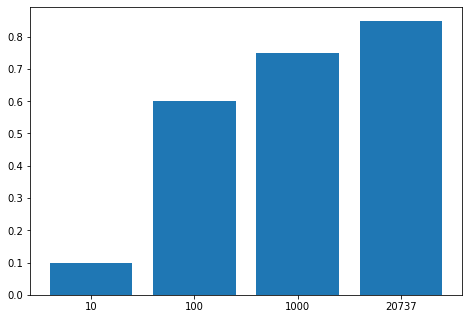

In [48]:
def 目標函數(database_size):
  correct = []
  for idx in tqdm(range(test_n)):
    o1 = 根據特定欄位和索引給出候選答案清單(
      col='產品名',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o2 = 根據特定欄位和索引給出候選答案清單(
      col='開狀人',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o3 = 根據特定欄位和索引給出候選答案清單(
      col='受益人',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o4 = 根據特定欄位和索引給出候選答案清單(
      col='開狀銀行',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o = o1+o3
    if len(set(o)&set(小公司列表)) > 0:
      o = list(set(o)&set(小公司列表))
    else:
      o = o1
    try:
      ensemble_output = max(o,key=o.count)
    except:
      ensemble_output = 'not find'
    # 計算正確率
    if ensemble_output == test_data['推薦公司事業部'][idx]:
      correct.append(True)
    else:
      correct.append(False)
  return np.mean(correct)
x = [10,100,1000,len(database)]
y = [目標函數(i) for i in x]
print(x,y)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([str(i) for i in x],y)
plt.show()

# 觀察不同database對正確率的影響

In [49]:
# 載入數據
database2 = pd.read_excel('../data/combined_excel_D.xlsx')

# 欄位定義
database2col = []
for i in database2.columns:
    if 'ERP' not in i:
        database2col.append(i)

# 欄位定義
database3col = []
for i in database2.columns:
    if '電文' not in i:
        database3col.append(i)

# 切分資料
database2,database3 = database2[database2col],database2[database3col]

# 統一命名
database2 = database2.rename(
    columns={
        '產品名_電文':'45A',
        '開狀人_電文':'50',
        '受益人_電文':'59',
        '開狀銀行_電文':'LTADDRESS.1',
        '出口代碼':'EXPNO',
    })
display(database2.head())

# 統一命名
database3 = database3.rename(
    columns={
        '產品名_ERP':'45A',
        '開狀人_ERP':'50',
        '受益人_ERP':'59',
        '開狀銀行_ERP':'LTADDRESS.1',
        '出口代碼':'EXPNO',
    })
display(database3.head())

,Unnamed: 0,信用狀代碼,EXPNO,TXDAT,59,45A,50,LTADDRESS.1,from
0,0,0505120IM0000875,11A11G09,20210120,"FORMOSA PLASTICS CORPORATION\r\n201, TUNG HWA ...",108.50 MT PVC RESIN SUSPENSION GRADE S-70 OF F...,RMG POLYVINYL INDIA LTD\r\n10/1 INDUSTRIAL ARE...,SBININBBAFXD,021-20201216-1231.xlsx
1,1,FDC0129000052021,11A11J95,20210130,NaN,NaN,NaN,NaN,NaN
2,2,FDC0129000052021,11A11J95,20210130,NaN,NaN,NaN,NaN,NaN
3,3,FDC0129000052021,11A11J95,20210130,NaN,NaN,NaN,NaN,NaN
4,4,1287IMLC22754,11A12F88,20210218,NaN,NaN,NaN,NaN,NaN


,Unnamed: 0,59,45A,50,LTADDRESS.1,信用狀代碼,EXPNO,TXDAT,from
0,0,FORMOSA PLASTICS,PVC RESIN SUSPENSION \nGRADE S-70,RMG POLYVINYL INDIA LTD\n10/1 INDUSTRIAL AREA\...,STATE BANK OF INDIA,0505120IM0000875,11A11G09,20210120,021-20201216-1231.xlsx
1,1,FORMOSA PLASTICS,"MASS PVC RESIN,GRADE B-57",RUBCHEM INDIA PVT LTD,THE SOUTH INDIAN BANK LTD,FDC0129000052021,11A11J95,20210130,NaN
2,2,FORMOSA PLASTICS,"PVC SUSPENSION RESIN,\nGRADE S-65",RUBCHEM INDIA PVT LTD,THE SOUTH INDIAN BANK LTD,FDC0129000052021,11A11J95,20210130,NaN
3,3,FORMOSA PLASTICS,"PVC SUSPENSION RESIN,\nGRADE S-65D",RUBCHEM INDIA PVT LTD,THE SOUTH INDIAN BANK LTD,FDC0129000052021,11A11J95,20210130,NaN
4,4,FORMOSA PLASTICS,PVC SUSPENSION RESIN \nS-65D,ALPHA POLYMERS,THE FEDERALBANK LTD\nP B NO 20 RAMAKRISHNA ROA...,1287IMLC22754,11A12F88,20210218,NaN


C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/20737 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

  0%|          | 0/42096 [00:00<?, ?it/s]

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

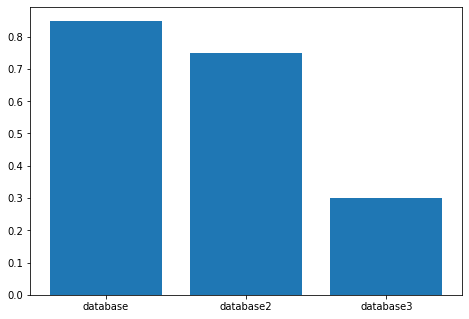

In [50]:
def 目標函數(database):
  database_size = len(database)
  correct = []
  for idx in tqdm(range(test_n)):
    o1 = 根據特定欄位和索引給出候選答案清單(
      col='產品名',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o2 = 根據特定欄位和索引給出候選答案清單(
      col='開狀人',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o3 = 根據特定欄位和索引給出候選答案清單(
      col='受益人',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o4 = 根據特定欄位和索引給出候選答案清單(
      col='開狀銀行',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o = o1+o3
    if len(set(o)&set(小公司列表)) > 0:
      o = list(set(o)&set(小公司列表))
    else:
      o = o1
    try:
      ensemble_output = max(o,key=o.count)
    except:
      ensemble_output = 'not find'
    # 計算正確率
    if ensemble_output == test_data['推薦公司事業部'][idx]:
      correct.append(True)
    else:
      correct.append(False)
  return np.mean(correct)
x = [抽特徵(預處理(database)),抽特徵(預處理(database2)),抽特徵(預處理(database3))]
y = [目標函數(i) for i in x]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['database','database2','database3'],y)
plt.show()

# 輸出預測結果

In [51]:
抽特徵(預處理(test_data))[輸出欄位+['推薦公司事業部']]

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2427 [00:00<?, ?it/s]

  0%|          | 0/2427 [00:00<?, ?it/s]

  0%|          | 0/2427 [00:00<?, ?it/s]

,產品名,開狀人,受益人,開狀銀行,推薦公司事業部
0,[PVC SUSPENSION RESIN],[DEEP JYOTI WAX TRADERS],[FORMOSA PLASTICS],ICICINBB,11
1,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],[NAN YA PLASTICS],CZNBKRSE,2A
2,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],[NAN YA PLASTICS],CZNBKRSE,2A
3,[PVC SUSPENSION RESIN],[GOVERDHAN ENERGY],[FORMOSA PLASTICS],INDBINBB,11
4,[PVC TRANSPARENT SHEET],[SOJITZ CORPORATION],[NAN YA PLASTICS],BOTKJPJT,21
...,...,...,...,...,...
2422,"[ETHYLENEPROPYLENE COPOLYMER, PLASTIC RESIN, P...",[DRACO KING INDUSTRIES LIMITED],[FORMOSA PLASTICS],HNBKHKHH,1P
2423,[MONO ETHYLENE GLYCOL],[CHI BAO CORPORATION],[NAN YA PLASTICS],TPBKTWTP,2A
2424,[RESIN],[PEGASUS CHEMICALS CO LTD],[FORMOSA PLASTICS],ICBCTWTP,11
2425,"[COVERING, GP5350]",[BRENNTAG CANADA INC],[FORMOSA CHEMICALS AND FIBRE],NOSCCATT,42


In [40]:
def 推論函數(database,test_data):
  test_data['預測EXPNO'] = None
  database_size = len(database)
  correct = []
  for idx in tqdm(range(test_n)):
    o1 = 根據特定欄位和索引給出候選答案清單(
      col='產品名',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o2 = 根據特定欄位和索引給出候選答案清單(
      col='開狀人',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o3 = 根據特定欄位和索引給出候選答案清單(
      col='受益人',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o4 = 根據特定欄位和索引給出候選答案清單(
      col='開狀銀行',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o = o1#+o2+o3+o4
    # 產生最終答案
    try:
      ensemble_output = max(o,key=o.count)
    except:
      ensemble_output = 'not find'
    test_data.loc[idx,'預測EXPNO'] = ensemble_output
    # 確認是否正確
    if ensemble_output == test_data['推薦公司事業部'][idx]:
      correct.append(True)
    else:
      correct.append(False)
  print('acc:',np.mean(correct))
  return test_data
test_data = 推論函數(database,test_data)
test_data.head()

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/20 [00:00<?, ?it/s]

acc: 0.85


,Unnamed: 0,項次,電文代號,銀行,20,回傳代碼,回傳訊息,建檔日期,受益人,金額,...,47A,78,LTADDRESS.1,memo,Unnamed: 5,產品名,開狀人,開狀銀行,處理過的資料,預測EXPNO
0,7,8,mt700,16,0006MLC00034022,200,"{""MESSAGE"":"""",""CODE"":200}",2021/09/24 12:31:17,[FORMOSA PLASTICS],"USD136080,00",...,1. ALL DOCUMENTS MUST BE IN ENGLISH.\r\n2. ALL...,UPON RECEIPT OF CREDIT COMPLIANT DOCUMENTS AT ...,ICICINBBACTS,NaN,NaN,[PVC SUSPENSION RESIN],[DEEP JYOTI WAX TRADERS],ICICINBB,ICICINBB,11
1,35,36,mt700,16,M100H2109SS00178,200,"{""MESSAGE"":"""",""CODE"":200}",2021/09/24 12:00:20,[NAN YA PLASTICS],"USD710000,",...,+ BOTH QUANTITY AND LC AMOUNT 5 PERCENT LESS I...,+THE AMOUNT OF EACH DRAWING MUST BE NOTED ON T...,CZNBKRSEAXXX,NaN,NaN,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],CZNBKRSE,CZNBKRSE,2A
2,36,37,mt700,16,M100H2109SS00185,200,"{""MESSAGE"":"""",""CODE"":200}",2021/09/24 12:00:38,[NAN YA PLASTICS],"USD710000,",...,- BOTH QUANTITY AND LC AMOUNT 5 PERCENT LESS I...,+THE AMOUNT OF EACH DRAWING MUST BE NOTED ON T...,CZNBKRSEAXXX,NaN,NaN,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],CZNBKRSE,CZNBKRSE,2A
3,37,38,mt700,16,OLC0025210044889,200,"{""MESSAGE"":"""",""CODE"":200}",2021/09/24 12:31:55,[FORMOSA PLASTICS],"USD140875,00",...,1. FIELD 50 APPLICANT DETAILS:\r\nGOVERDHAN EN...,THE NEGOTIATING BANK TO COURIER FULL SET OF DO...,INDBINBBANAS,NaN,NaN,[PVC SUSPENSION RESIN],[GOVERDHAN ENERGY],INDBINBB,INDBINBB,11
4,38,39,mt700,16,S-321-2021242,200,"{""MESSAGE"":"""",""CODE"":200}",2021/09/24 12:40:42,[NAN YA PLASTICS],"USD39631,45",...,+ALL DOCUMENTS MUST BE ISSUED IN ENGLISH LANGU...,REIMBURSEMENT BY TELECOMMUNICATION IS PROHIBIT...,BOTKJPJTAXXX,NaN,NaN,[PVC TRANSPARENT SHEET],[SOJITZ CORPORATION],BOTKJPJT,BOTKJPJT,21


In [42]:
test_n = len(test_data)
def 推論函數(database,test_data):
  test_data['預測EXPNO'] = None
  database_size = len(database)
  correct = []
  for idx in tqdm(range(test_n)):
    o1 = 根據特定欄位和索引給出候選答案清單(
      col='產品名',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o2 = 根據特定欄位和索引給出候選答案清單(
      col='開狀人',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o3 = 根據特定欄位和索引給出候選答案清單(
      col='受益人',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o4 = 根據特定欄位和索引給出候選答案清單(
      col='開狀銀行',idx=idx,k=3,
      database_size=database_size,
      database=database,test_data=test_data)
    o = o1#+o2+o3+o4
    # 產生最終答案
    try:
      ensemble_output = max(o,key=o.count)
    except:
      ensemble_output = 'not find'
    test_data.loc[idx,'預測EXPNO'] = ensemble_output
    # 確認是否正確
    if ensemble_output == test_data['推薦公司事業部'][idx]:
      correct.append(True)
    else:
      correct.append(False)
  print('acc:',np.mean(correct))
  return test_data
test_data = 推論函數(database,test_data)
test_data.head()

C:\Users\ricky\anaconda3\envs\bert_env\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/2427 [00:00<?, ?it/s]

acc: 0.6975690152451587


,Unnamed: 0,項次,電文代號,銀行,20,回傳代碼,回傳訊息,建檔日期,受益人,金額,...,47A,78,LTADDRESS.1,memo,Unnamed: 5,產品名,開狀人,開狀銀行,處理過的資料,預測EXPNO
0,7,8,mt700,16,0006MLC00034022,200,"{""MESSAGE"":"""",""CODE"":200}",2021/09/24 12:31:17,[FORMOSA PLASTICS],"USD136080,00",...,1. ALL DOCUMENTS MUST BE IN ENGLISH.\r\n2. ALL...,UPON RECEIPT OF CREDIT COMPLIANT DOCUMENTS AT ...,ICICINBBACTS,NaN,NaN,[PVC SUSPENSION RESIN],[DEEP JYOTI WAX TRADERS],ICICINBB,ICICINBB,11
1,35,36,mt700,16,M100H2109SS00178,200,"{""MESSAGE"":"""",""CODE"":200}",2021/09/24 12:00:20,[NAN YA PLASTICS],"USD710000,",...,+ BOTH QUANTITY AND LC AMOUNT 5 PERCENT LESS I...,+THE AMOUNT OF EACH DRAWING MUST BE NOTED ON T...,CZNBKRSEAXXX,NaN,NaN,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],CZNBKRSE,CZNBKRSE,2A
2,36,37,mt700,16,M100H2109SS00185,200,"{""MESSAGE"":"""",""CODE"":200}",2021/09/24 12:00:38,[NAN YA PLASTICS],"USD710000,",...,- BOTH QUANTITY AND LC AMOUNT 5 PERCENT LESS I...,+THE AMOUNT OF EACH DRAWING MUST BE NOTED ON T...,CZNBKRSEAXXX,NaN,NaN,[MONO ETHYLENE GLYCOL MEG],[CHEMNEWS CORP],CZNBKRSE,CZNBKRSE,2A
3,37,38,mt700,16,OLC0025210044889,200,"{""MESSAGE"":"""",""CODE"":200}",2021/09/24 12:31:55,[FORMOSA PLASTICS],"USD140875,00",...,1. FIELD 50 APPLICANT DETAILS:\r\nGOVERDHAN EN...,THE NEGOTIATING BANK TO COURIER FULL SET OF DO...,INDBINBBANAS,NaN,NaN,[PVC SUSPENSION RESIN],[GOVERDHAN ENERGY],INDBINBB,INDBINBB,11
4,38,39,mt700,16,S-321-2021242,200,"{""MESSAGE"":"""",""CODE"":200}",2021/09/24 12:40:42,[NAN YA PLASTICS],"USD39631,45",...,+ALL DOCUMENTS MUST BE ISSUED IN ENGLISH LANGU...,REIMBURSEMENT BY TELECOMMUNICATION IS PROHIBIT...,BOTKJPJTAXXX,NaN,NaN,[PVC TRANSPARENT SHEET],[SOJITZ CORPORATION],BOTKJPJT,BOTKJPJT,21


In [46]:
test_data[輸出欄位+['推薦公司事業部','預測EXPNO']].to_excel('../predict_result/預測結果.xlsx')